In [227]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
import seaborn as sns
import pickle
import os

def train_test_split_season(df, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
    df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
    df_test = df[df['season'] == season_test]
    return df_train, df_test

In [228]:
df = pd.read_csv("data/all_game_data_milesstone_2.csv")
train, test = train_test_split(df)

In [229]:

y = train['is_goal']
x = train[['shot_distance_to_goal', 'shot_angle']]
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)

DISTANCE AND ANGLE

In [230]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    fig = plt.gcf()
    plt.show()
    return fig
def plot_goal_rate_vs_percentile(y_true, y_prob, bins=10):
    percentiles = np.percentile(y_prob, np.linspace(0, 100, bins))
    avg_goal_rate = [np.mean(y_true[y_prob >= p]) for p in percentiles]

    plt.figure(figsize=(8, 6))
    plt.plot(percentiles, avg_goal_rate, marker='o')
    plt.xlabel('Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.title('Goal Rate vs Probability Percentile')
    fig = plt.gcf()
    plt.show()
    return fig

def plot_cumulative_proportion_of_goals(y_true, y_prob, bins=10):
    percentiles = np.percentile(y_prob, np.linspace(0, 100, bins))
    cumulative_goals = [np.sum(y_true[y_prob >= p]) for p in percentiles]
    total_goals = np.sum(y_true)
    print(total_goals)
    cumulative_proportion = np.cumsum(cumulative_goals) 
    print(cumulative_proportion)
    cumulative_proportion = [element / total_goals for element in cumulative_proportion]
    plt.figure(figsize=(8, 6))
    plt.plot(percentiles, cumulative_proportion, marker='o')
    plt.xlabel('Probability Percentile')
    plt.ylabel('Cumulative Proportion of Goals')
    plt.title('Cumulative Proportion of Goals vs Probability Percentile')
    fig = plt.gcf()
    plt.show()
    return fig

def plot_reliability_curve(y_true, y_prob, bins=10):
    prob_bins = np.linspace(0, 1, bins + 1)
    centers = (prob_bins[:-1] + prob_bins[1:]) / 2

    empirical_prob = [np.mean(y_prob[(y_prob >= prob_bins[i]) & (y_prob < prob_bins[i+1])]) for i in range(bins)]
    fraction_of_positives = [np.mean(y_true[(y_prob >= prob_bins[i]) & (y_prob < prob_bins[i+1])]) for i in range(bins)]

    plt.figure(figsize=(8, 6))
    plt.plot(centers, empirical_prob, marker='o', label='Empirical')
    plt.plot(centers, fraction_of_positives, marker='o', linestyle='--', label='Fraction of Positives')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Curve')
    plt.legend()
    fig = plt.gcf()
    plt.show()
    return fig



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/facd18dd18c74fe293af812f1be9d5eb



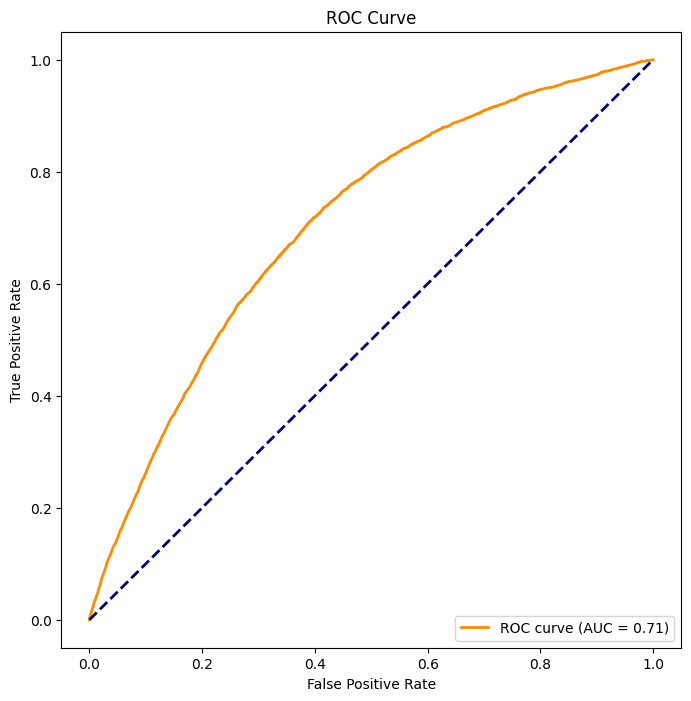

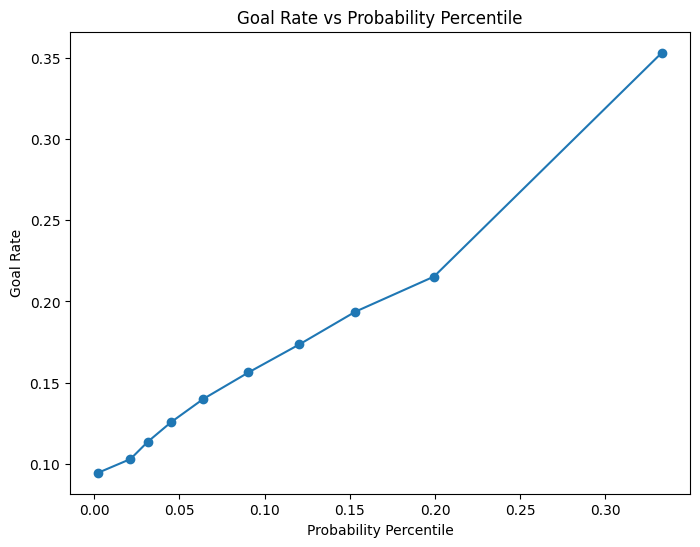

5506
[ 5506 10836 15978 20857 25383 29425 32799 35304 36705 36717]


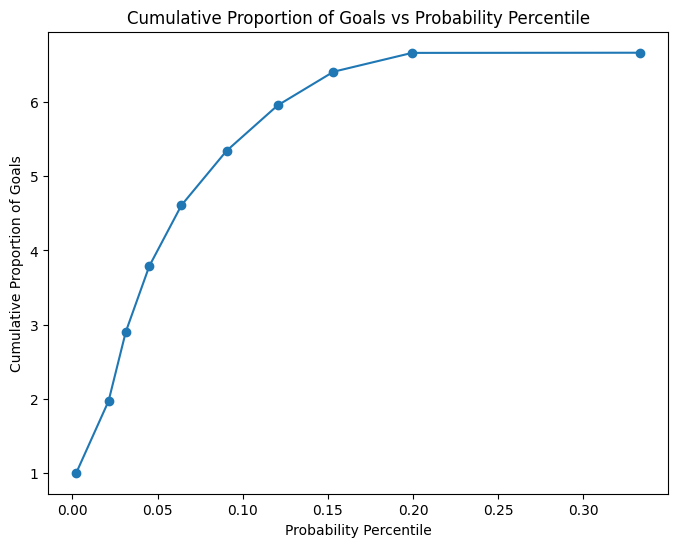

c:\Users\Mahdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mahdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


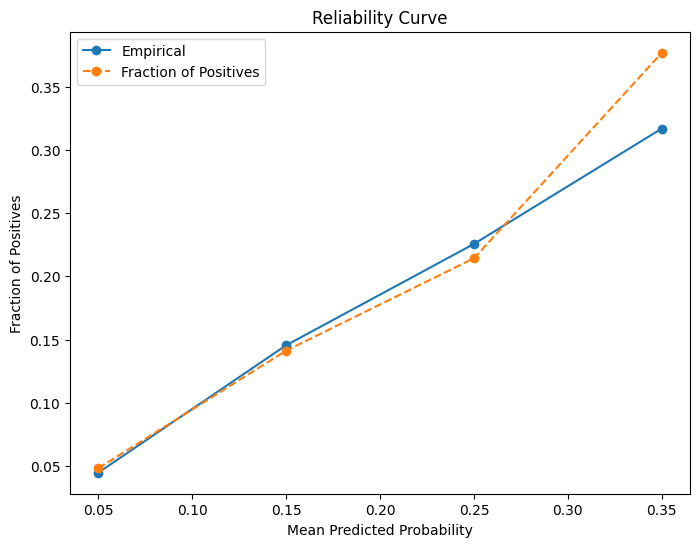

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/facd18dd18c74fe293af812f1be9d5eb
COMET INFO:   Metrics:
COMET INFO:     ROC AUC score : 0.5
COMET INFO:     accuracy      : 0.905354533734422
COMET INFO:     f1 score      : 0.0
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (38.40 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To ge

In [231]:
experiment = Experiment(api_key='h85xbEnyF7lyFkSRYhBshWV8E', project_name="nhl-data-science", workspace="mahmoodhegazy")


xgb_da = xgb.XGBClassifier()
xgb_da.fit(X_train, y_train)
preds = xgb_da.predict(X_val)

experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f1 score', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score', roc_auc_score(y_val, preds))



y_prob = xgb_da.predict_proba(X_val)[:, 1]

p1 = plot_roc_curve(y_val, y_prob)
p2=plot_goal_rate_vs_percentile(y_val, y_prob)
p3=plot_cumulative_proportion_of_goals(y_val, y_prob)
p4=plot_reliability_curve(y_val, y_prob)


experiment.log_figure(figure=p1, figure_name='ROC Curve with Distance and Angle', step=None)
experiment.log_figure(figure=p2,figure_name='Goal Rate with Distance and Angle', step=None)
experiment.log_figure(figure=p3,figure_name='Cumulative goal % with Distance and Angle', step=None)
experiment.log_figure(figure=p4,figure_name='Calibration curve with Distance and Angle', step=None)
experiment.end()


Q2


In [232]:
X_cols = ['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate', 'shot_distance_to_goal', 'shot_angle', 'shot_type',
'last_x_coordinate', 'last_y_coordinate', 'last_event', 'time_from_last_event', 'distance_from_last_event', 'rebound', 'speed',
'time_since_powerplay_started', 'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters']
y_cols = ['is_goal']
train_val, y = train[X_cols], train[y_cols]


train_val['rebound'] = train_val['rebound'].astype(int)
train_val['last_event'] = pd.Categorical(train_val['last_event'])
onehot_encoded_df = pd.get_dummies(train_val, columns=['last_event'], prefix='last_event')

onehot_encoded_df['shot_type'] = pd.Categorical(onehot_encoded_df['shot_type'])
onehot_encoded_df = pd.get_dummies(onehot_encoded_df, columns=['shot_type'], prefix='shot_type')

train_val = onehot_encoded_df.fillna(0).astype(int)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_10936\2221030929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['rebound'] = train_val['rebound'].astype(int)
C:\Users\Mahdi\AppData\Local\Temp\ipykernel_10936\2221030929.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['last_event'] = pd.Categorical(train_val['last_event'])


In [233]:
X_train, X_val, y_train, y_val = train_test_split(train_val, y, test_size=0.2, random_state=10)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/af53ad308cc047249cd1b547201778a6



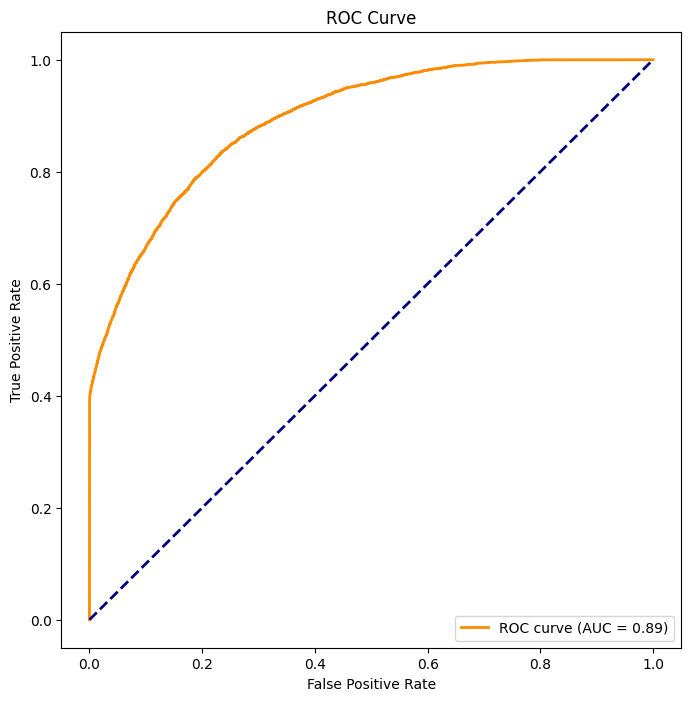

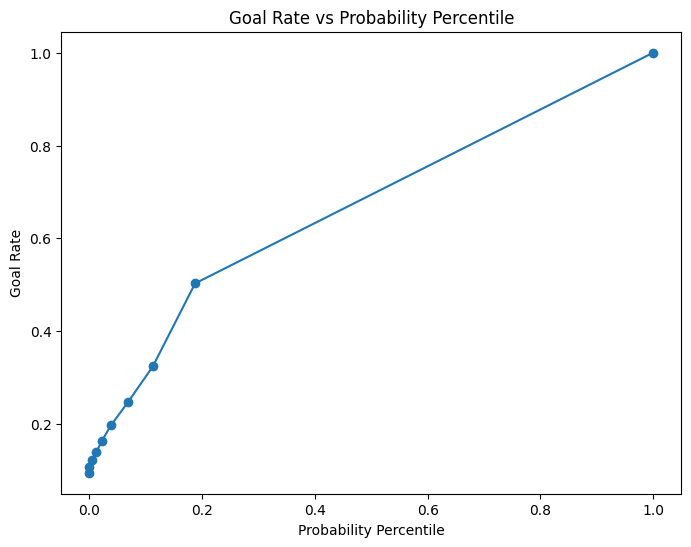

is_goal    5506
dtype: int64
[ 5506 11012 16505 21936 27231 32321 37094 41278 44528 44529]


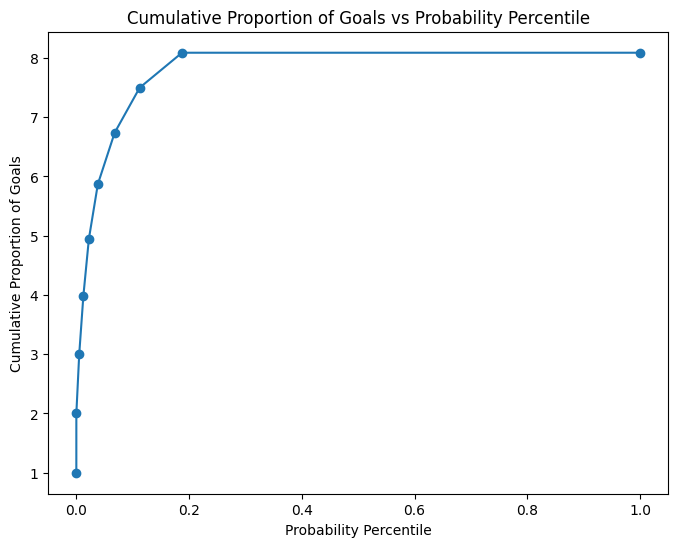

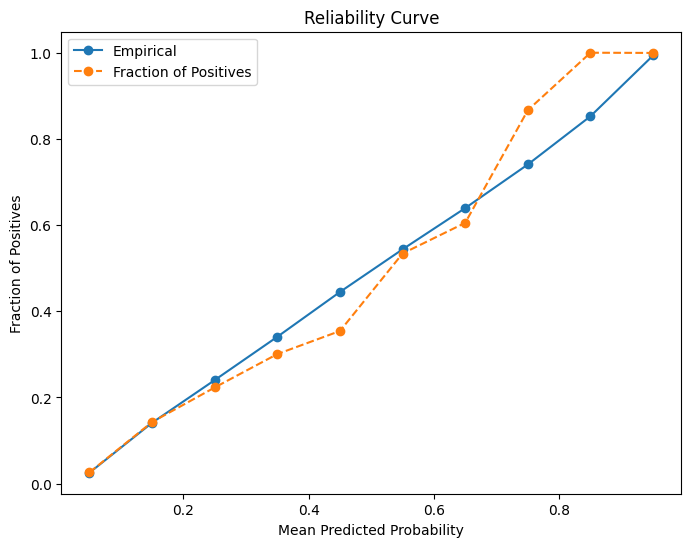

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/af53ad308cc047249cd1b547201778a6
COMET INFO:   Metrics:
COMET INFO:     ROC-AUC  : 0.7011289647052954
COMET INFO:     accuracy : 0.942518263859046
COMET INFO:     f-score  : 0.5705111739018752
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (38.40 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET

In [234]:

experiment = Experiment(api_key='h85xbEnyF7lyFkSRYhBshWV8E', project_name="nhl-data-science", workspace="mahmoodhegazy")

xgb_da = xgb.XGBClassifier()
xgb_da.fit(X_train, y_train)
preds = xgb_da.predict(X_val)

experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f-score', f1_score(y_val, preds))
experiment.log_metric('ROC-AUC', roc_auc_score(y_val, preds))



y_prob = xgb_da.predict_proba(X_val)[:,1]

p1 = plot_roc_curve(y_val, y_prob)
p2 = plot_goal_rate_vs_percentile(y_val, y_prob)
p3 = plot_cumulative_proportion_of_goals(y_val, y_prob)
p4 = plot_reliability_curve(y_val, y_prob)


experiment.log_figure(figure=p1, figure_name='ROC Curve with all', step=None)
experiment.log_figure(figure=p2,figure_name='Goal Rate with all', step=None)
experiment.log_figure(figure=p3,figure_name='Cumulative goal % all', step=None)
experiment.log_figure(figure=p4,figure_name='Calibration curve with all', step=None)


experiment.end()


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/457de12cf0f34647a85e4f194a96d9ea
COMET INFO:   Metrics:
COMET INFO:     ROC AUC score after cross-val : 0.698406289829711
COMET INFO:     accuracy after cross-val      : 0.9427417275461968
COMET INFO:     f1 score after cross-val      : 0.5675710762040764
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (38.40 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1


Fitting 3 folds for each of 27 candidates, totalling 81 fits


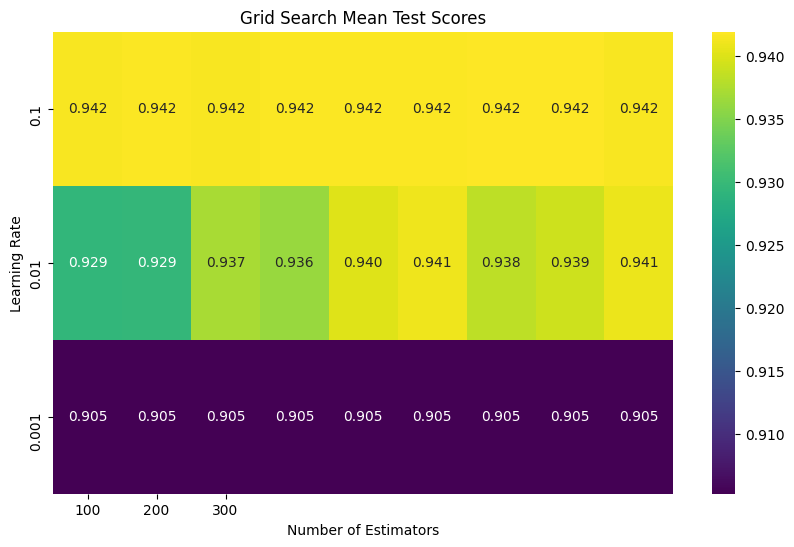

{'web': 'https://www.comet.com/api/image/download?imageId=2ec7550672a8443db34116a63b93b734&experimentKey=8a9e8e36aa184514a2a98e6ea89d7396',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=2ec7550672a8443db34116a63b93b734&experimentKey=8a9e8e36aa184514a2a98e6ea89d7396',
 'imageId': '2ec7550672a8443db34116a63b93b734'}

In [246]:
#  https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
experiment = Experiment(api_key='h85xbEnyF7lyFkSRYhBshWV8E', project_name="nhl-data-science", workspace="mahmoodhegazy")

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7],
}

xgb_da = xgb.XGBClassifier()

grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_

preds = best_xgb_da.predict(X_val)

accuracy = accuracy_score(y_val, preds)

results = grid_search.cv_results_

mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['n_estimators'],
    yticklabels=param_grid['learning_rate'],
    fmt=".3f",  
)

plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

experiment.log_metric('accuracy after cross-val', accuracy_score(y_val, preds))
experiment.log_metric('f1 score after cross-val', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score after cross-val', roc_auc_score(y_val, preds))
experiment.log_figure(figure=f1, figure_name='ROC Curve with all', step=None)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


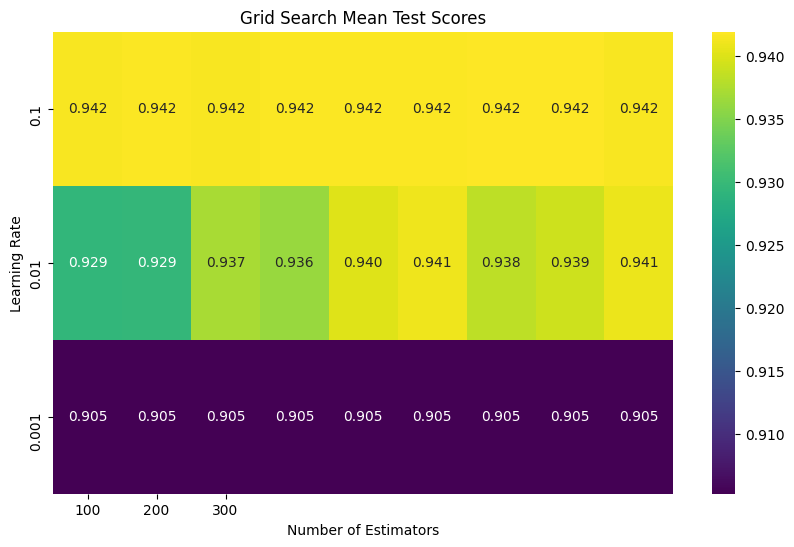

{'web': 'https://www.comet.com/api/image/download?imageId=855f1e46378f43b998a13c1827921b7c&experimentKey=8a9e8e36aa184514a2a98e6ea89d7396',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=855f1e46378f43b998a13c1827921b7c&experimentKey=8a9e8e36aa184514a2a98e6ea89d7396',
 'imageId': '855f1e46378f43b998a13c1827921b7c'}

In [247]:


grid_search = GridSearchCV(
    xgb_da,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
xgb_da = xgb.XGBClassifier()
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_

preds = best_xgb_da.predict(X_val)

accuracy = accuracy_score(y_val, preds)

results = grid_search.cv_results_

mean_test_scores = results['mean_test_score'].reshape(len(param_grid['learning_rate']), -1)

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_test_scores,
    annot=True,
    cmap='viridis',
    xticklabels=param_grid['n_estimators'],
    yticklabels=param_grid['learning_rate'],
    fmt=".3f",  
)

plt.title('Grid Search Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
f1 = plt.gcf()
plt.show()

experiment.log_metric('accuracy after cross-val', accuracy_score(y_val, preds))
experiment.log_metric('f1 score after cross-val', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score after cross-val', roc_auc_score(y_val, preds))
experiment.log_figure(figure=f1, figure_name='ROC Curve with all', step=None)



In [ ]:
param_grid = {
    'learning_rate': [10,1,0.1, 0.01, 0.001],
    'n_estimators': [100, 150,200],
    'max_depth': [7, 8, 9, 10],
}
xgb_da = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_da, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_da = grid_search.best_estimator_

preds = best_xgb_da.predict(X_val)

accuracy = accuracy_score(y_val, preds)
experiment.log_metric('accuracy after cross-val', accuracy_score(y_val, preds))
experiment.log_metric('f1 score after cross-val', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score after cross-val', roc_auc_score(y_val, preds))